In [48]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.metrics import f1_score
import tensorflow as tf
import datetime
from ml_utils.data_ext  import create_new_road_data

%load_ext autoreload
%autoreload 2
    
import ml_utils.road_seg as rs
import ml_utils.model as model
from ml_utils.canny_layer import add_canny_layer_imgs

print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.4.0


# 1. Loading and Preprocessing

Load raw images and ground truth

In [59]:
### Create new 400 images (roated, mirrored, flipped) in th other folder from original data:
### AUGMENTED DATA GENERATION HERE 
create_new_road_data(400,'data/training/groundtruth', 'data/training/images' )

Processing satImage_091.png:   1%|          | 3/400 [00:00<00:17, 22.13 Samples/s]

Initialised with 100 image(s) found.
Output directory set to data/training/images/output.

Processing satImage_047.png:   2%|▏         | 6/400 [00:00<00:07, 51.97 Samples/s]  

Initialised with 100 image(s) found.
Output directory set to data/training/groundtruth/output.

Renaming groundtruth_8b1188bf-7f98-4125-a7f1-aacb1a1f7536.JPEG to satImage_001.png
Renaming groundtruth_0207eba1-1664-4069-ac2a-277b035ad6b5.JPEG to satImage_002.png
Renaming groundtruth_5beef37d-f477-4220-ad78-b892d550c632.JPEG to satImage_003.png
Renaming groundtruth_0c4a185c-d78f-4ea7-949b-c312f908e25c.JPEG to satImage_004.png
Renaming groundtruth_91bfb5d1-768e-4fbd-a1b9-81df5b41330b.JPEG to satImage_005.png
Renaming groundtruth_03a888a5-588d-44fb-90a4-b8f8bf3a4539.JPEG to satImage_006.png
Renaming groundtruth_06c53d67-a4e9-42c3-be90-cda7b9f50d76.JPEG to satImage_007.png
Renaming groundtruth_74ac05f3-4cde-42bc-8f0d-60b4f123356f.JPEG to satImage_008.png
Renaming groundtruth_25bbfbfe-d914-4ebf-9b00-efcc7f0accc7.JPEG to satImage_009.png
Renaming groundtruth_73d5cbff-8a96-47f1-887a-34d2c46badd4.JPEG to satImage_010.png
Renaming groundtruth_dfd024ed-ed92-4665-a6f4-e8dd6a1a0faa.JPEG to satImage_011.png
Renaming groundtruth_d29d2478-3409-4827-ba7c-8254f49b319f.JPEG to satImage_012.png
Rena

Renaming groundtruth_c97ab9eb-5611-4746-bdbf-e9f59de45d45.JPEG to satImage_102.png
Renaming groundtruth_a994f592-ed70-45ca-8aae-3ad9dcb9b5bb.JPEG to satImage_103.png
Renaming groundtruth_f0a0dc45-c55e-44c6-932c-2bad4d5927df.JPEG to satImage_104.png
Renaming groundtruth_7f882b2d-04a5-4866-94a1-6d7b1efa69f7.JPEG to satImage_105.png
Renaming groundtruth_6db83aa1-60e9-4bfd-92bb-ba92b7ec6a71.JPEG to satImage_106.png
Renaming groundtruth_8e0f3672-621f-4f92-93ce-83825d582906.JPEG to satImage_107.png
Renaming groundtruth_4704a0f2-461a-4a21-b1fc-d02a7b08c5c5.JPEG to satImage_108.png
Renaming groundtruth_1dd1683d-93d0-48c0-ba5a-db7ea901f0a3.JPEG to satImage_109.png
Renaming groundtruth_582d8e2e-931f-41be-aff7-241758bc3d61.JPEG to satImage_110.png
Renaming groundtruth_7c8a1467-ff3c-4ab4-a806-620146100481.JPEG to satImage_111.png
Renaming groundtruth_2dd84624-4a4f-4530-bed6-056bf3e18933.JPEG to satImage_112.png
Renaming groundtruth_12a3a22e-57a0-411d-bb52-f953ccfde01a.JPEG to satImage_113.png
Rena

Renaming groundtruth_a7beef95-aa21-4eda-8863-1c9dbe3343bd.JPEG to satImage_202.png
Renaming groundtruth_98f70481-1aa0-46fc-bf43-491dfb8204e9.JPEG to satImage_203.png
Renaming groundtruth_eebec2b9-057a-4848-9269-d3cde80ac386.JPEG to satImage_204.png
Renaming groundtruth_bdb1c077-6846-43fe-a9d1-944aa46d2b09.JPEG to satImage_205.png
Renaming groundtruth_5bdbc6d6-1466-49f0-b528-c3d7797696fb.JPEG to satImage_206.png
Renaming groundtruth_89457ea7-e1bb-4576-a978-84c6bc07e075.JPEG to satImage_207.png
Renaming groundtruth_d3543a60-bacd-436a-96e1-7debb02501ea.JPEG to satImage_208.png
Renaming groundtruth_46357e45-0fcf-4eda-a579-8635889c94db.JPEG to satImage_209.png
Renaming groundtruth_e9a50b87-0396-49ce-89b7-fd4b19ec6bcd.JPEG to satImage_210.png
Renaming groundtruth_15ea0923-e047-4f8d-8b58-3b8ca6cfd2c5.JPEG to satImage_211.png
Renaming groundtruth_7fe12843-e0a8-44dd-888a-ad6140c2f075.JPEG to satImage_212.png
Renaming groundtruth_7f8f1288-8ad7-4c89-8724-3076c50b9d1f.JPEG to satImage_213.png
Rena

Renaming groundtruth_edd453d8-17d5-411d-844a-89e68578c899.JPEG to satImage_306.png
Renaming groundtruth_dd906ce5-b0e6-4bc9-a95e-ba2d563c2553.JPEG to satImage_307.png
Renaming groundtruth_f835a487-0528-4ff3-839b-403a8955ccf7.JPEG to satImage_308.png
Renaming groundtruth_7fffb31e-99b3-49dc-9483-a4e565d39c8a.JPEG to satImage_309.png
Renaming groundtruth_325ffd6d-03b5-484f-87b4-e8859ea1381d.JPEG to satImage_310.png
Renaming groundtruth_845400e6-8f8c-439a-8f79-f0be338b80a5.JPEG to satImage_311.png
Renaming groundtruth_b4cb9af7-f93f-44f0-88fd-318d02fe010c.JPEG to satImage_312.png
Renaming groundtruth_8791ba5b-03a1-498a-a57e-f006021a14e5.JPEG to satImage_313.png
Renaming groundtruth_0be6769d-b5c5-472d-86a5-68ec0eaec1c6.JPEG to satImage_314.png
Renaming groundtruth_d0029edb-926c-4191-b792-97226f4fe06b.JPEG to satImage_315.png
Renaming groundtruth_68c1fec5-c29a-496e-bcdd-5add5275294c.JPEG to satImage_316.png
Renaming groundtruth_6897e198-3db7-48d7-94ac-87f1b0ecf93a.JPEG to satImage_317.png
Rena

Renaming images_5c1d6711-b510-4f80-ba65-e0b0ad066922.JPEG to satImage_005.png
Renaming images_86c79370-7f13-43e3-a504-c06dad5eb7c3.JPEG to satImage_006.png
Renaming images_e254884c-aa2c-40b3-9f59-dc9917b17a0d.JPEG to satImage_007.png
Renaming images_4a199ced-95bb-4b1f-a62b-7b516a564002.JPEG to satImage_008.png
Renaming images_12d4e84c-ee07-4ba5-9e50-a146f95ab6ca.JPEG to satImage_009.png
Renaming images_7149c036-5518-4fd1-a733-03874a0079a0.JPEG to satImage_010.png
Renaming images_b462c6ce-46eb-4647-9ab3-e52c81137e5d.JPEG to satImage_011.png
Renaming images_9013513e-6210-4f38-8d05-353a867c7d96.JPEG to satImage_012.png
Renaming images_32428dc7-1115-4031-94ef-fa20b6637905.JPEG to satImage_013.png
Renaming images_0e12325e-a1fa-469a-a9d7-947e9dfbf1b3.JPEG to satImage_014.png
Renaming images_4874ebb8-7e2d-4e1d-a399-4736c385a8ba.JPEG to satImage_015.png
Renaming images_1ed0c747-2585-4d3f-8146-3cea0c835061.JPEG to satImage_016.png
Renaming images_6943a9fd-3dfa-4220-a672-7ac19f353056.JPEG to sat

Renaming images_2fd986f7-f01f-4ff0-8872-f8827ea034cc.JPEG to satImage_114.png
Renaming images_68e5a7d7-12eb-44fd-9d6e-a066ac9ea5d9.JPEG to satImage_115.png
Renaming images_509d3cec-b3fa-4e0e-8b4e-20491ba638ee.JPEG to satImage_116.png
Renaming images_f7a30a47-b5c7-4f7b-924b-0c8918c26706.JPEG to satImage_117.png
Renaming images_fcd8e7ce-09aa-4659-8c03-c13dc96e3824.JPEG to satImage_118.png
Renaming images_98219285-692c-48b9-b57d-1f79b8c260c5.JPEG to satImage_119.png
Renaming images_34dde334-6947-4e32-816a-8497a3f94c25.JPEG to satImage_120.png
Renaming images_979f19e4-580e-4ff4-8713-a95ee87bcec3.JPEG to satImage_121.png
Renaming images_11f3323a-09b9-4c79-838b-8c74d44f6c76.JPEG to satImage_122.png
Renaming images_a516fd5a-2c23-4373-8728-d79ff48360b5.JPEG to satImage_123.png
Renaming images_a61bb449-782d-4653-844b-928ef94d5157.JPEG to satImage_124.png
Renaming images_306f9089-27f7-4b2e-b14d-f785b6b849a7.JPEG to satImage_125.png
Renaming images_9551314e-cc82-405c-a5b5-2a2466a39d2d.JPEG to sat

Renaming images_0aee9a05-fc0e-4c6b-b3df-0b6f3f46b016.JPEG to satImage_220.png
Renaming images_92775b45-1e08-4678-ae76-7c04e43aabb3.JPEG to satImage_221.png
Renaming images_188901d1-d09e-41a8-b12f-b7ff278712fb.JPEG to satImage_222.png
Renaming images_0aa78945-8a94-4038-9885-926f4fdc1741.JPEG to satImage_223.png
Renaming images_38731441-fa22-4568-b61e-11956bb7b3da.JPEG to satImage_224.png
Renaming images_448f103b-0882-4166-808f-61c6cb6504e6.JPEG to satImage_225.png
Renaming images_1f7df302-8b00-469e-9645-ecc1165ecf84.JPEG to satImage_226.png
Renaming images_458803cd-aa8d-4833-9e38-8c65f1d8909a.JPEG to satImage_227.png
Renaming images_b6574859-6159-4ce0-9aef-0d0e7b50b037.JPEG to satImage_228.png
Renaming images_91772cab-51a3-452a-9784-1e216148c23f.JPEG to satImage_229.png
Renaming images_242b5fae-330d-411f-bf82-62db361a606b.JPEG to satImage_230.png
Renaming images_e7edea70-1dbc-4b36-82dd-3e72108818d2.JPEG to satImage_231.png
Renaming images_d571e40e-6097-4c78-9176-e10ae74d80d5.JPEG to sat

Renaming images_8329028d-68d8-4709-954e-c8ef82795951.JPEG to satImage_326.png
Renaming images_5b284127-0c20-49f6-8761-014b56c201c3.JPEG to satImage_327.png
Renaming images_dd01878b-041c-46a9-9559-db940268c2c1.JPEG to satImage_328.png
Renaming images_63a9cb48-023f-4831-bbe1-d43a48b13374.JPEG to satImage_329.png
Renaming images_962ac032-5594-4075-afdc-0407c75c4bf1.JPEG to satImage_330.png
Renaming images_83d280a6-3257-4b08-8a21-9b1501b2e182.JPEG to satImage_331.png
Renaming images_c69498da-1997-4ffa-807c-2bc0cafa1880.JPEG to satImage_332.png
Renaming images_5b7531db-5f98-4b5e-b1cc-fa8ecba85fc8.JPEG to satImage_333.png
Renaming images_7f4dd87a-cc48-4ff7-910f-13513f9b2767.JPEG to satImage_334.png
Renaming images_bb4e3c4c-c9cf-4caf-a017-cc4f3ae0acc3.JPEG to satImage_335.png
Renaming images_74828c3f-024c-4b8b-9904-9881788c54c5.JPEG to satImage_336.png
Renaming images_3efbd898-de1d-4f4c-861f-006eb1c89fb9.JPEG to satImage_337.png
Renaming images_ecaaefee-b728-4ad3-8f55-11c2b3f2a312.JPEG to sat

In [60]:
path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_test = os.path.join(path_data, 'test_set_images')
path_models = 'model'

if not os.path.exists(path_models):
    os.mkdir(path_models)
#train_imgs, train_gt, val_imgs, val_gt, id_train, id_valid = rs.load_train_set(path_train_dir, ratio=0.8)

# uncomment the line above not to use augmented data
train_imgs, train_gt, val_imgs, val_gt, id_train, id_valid = rs.load_train_set(path_train_dir,
                                                                               use_augmented=True, 

                                                                               #ratio=0.8)
## IDK when using augmentation it reads the mask image as RGB
train_gt = train_gt.mean(axis=3)   
val_gt = val_gt.mean(axis=3)                                                                                 

(320, 400, 400, 3)

In [65]:
print(train_gt.shape)
print(val_gt.shape)

(320, 400, 400)
(80, 400, 400)


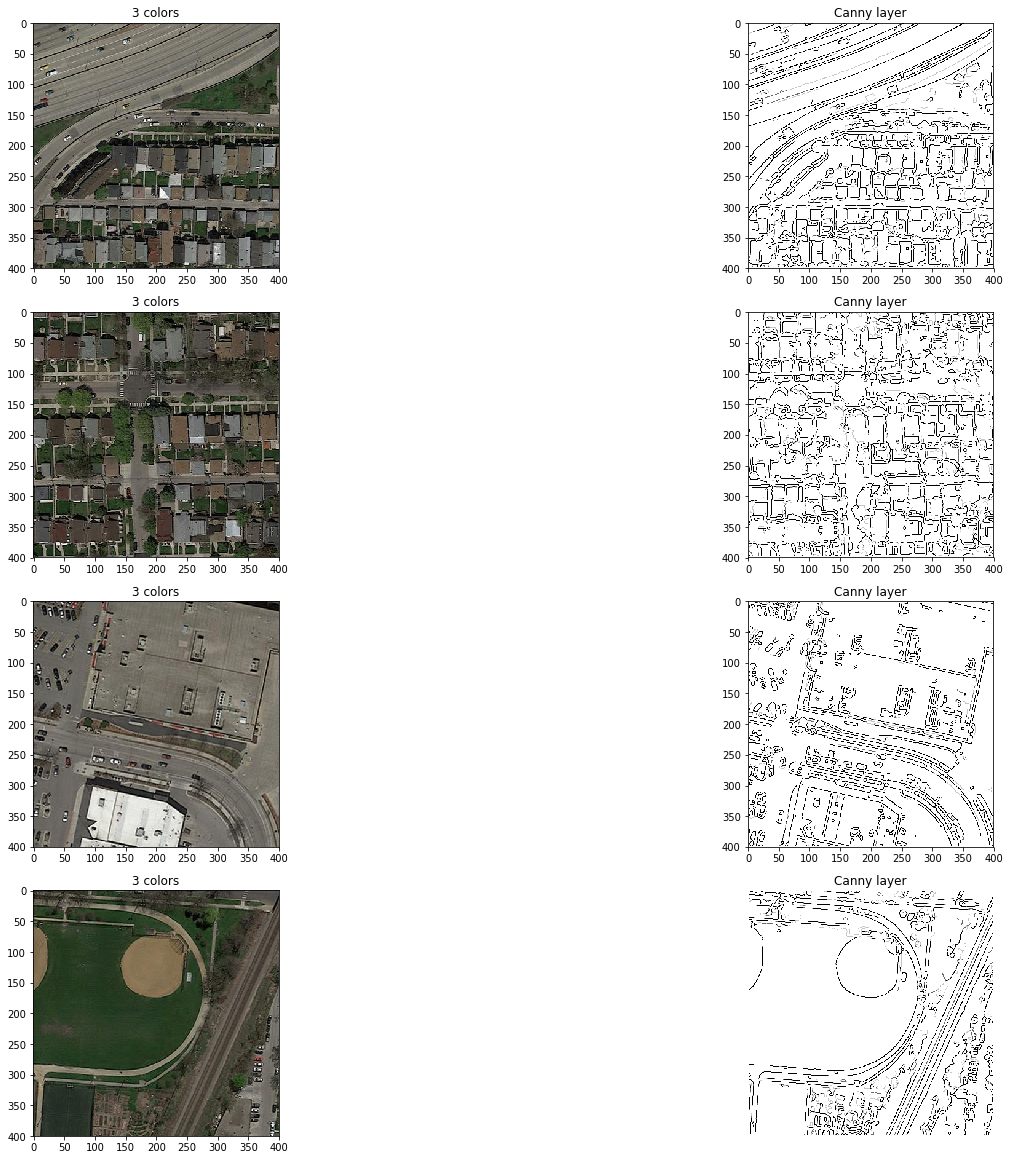

In [66]:
train_imgs_added_canny = add_canny_layer_imgs(train_imgs, sigma=1.5,plot_random=True, nr_plot_imgs=3) 
val_imgs_added_canny = add_canny_layer_imgs(val_imgs, sigma=1.5) 

train_imgs_norm, mean_train, std_train = rs.normalize_data(train_imgs_added_canny, mode='all')
val_imgs_norm, _, _ = rs.normalize_data(val_imgs_added_canny, mode='all', mean_ref=mean_train, std_ref=std_train)

Generate smaller images for training

In [67]:
patch_size = 80
patch_tr, lab_tr,_ = rs.get_patches_all(train_imgs_norm, train_gt, patch_size)
patch_val, lab_val,_ = rs.get_patches_all(val_imgs_norm, val_gt, patch_size)

print('Shapes train: {},  test: {}'.format(patch_tr.shape, patch_val.shape))

Shapes train: (8000, 80, 80, 4),  test: (2000, 80, 80, 4)


Take only part of train and validation set (should at least contain a part of the road)

In [73]:
useful_patches_tr, useful_lab_tr = rs.get_useful_patches(patch_tr, lab_tr, 0.2, 0.7)
useful_patches_val, useful_lab_val = rs.get_useful_patches(patch_val, lab_val, 0.2, 0.7)
useful_lab_tr = useful_lab_tr.astype(int)
useful_lab_val = useful_lab_val.astype(int)

print('Shapes train: {},  test: {}'.format(useful_patches_tr.shape, useful_patches_val.shape))

999 / 8000
1999 / 8000
2999 / 8000
3999 / 8000
4999 / 8000
5999 / 8000
6999 / 8000
7999 / 8000
999 / 2000
1999 / 2000
Shapes train: (3062, 80, 80, 4),  test: (761, 80, 80, 4)


# 2. Model training

Display patches example with label ground truth

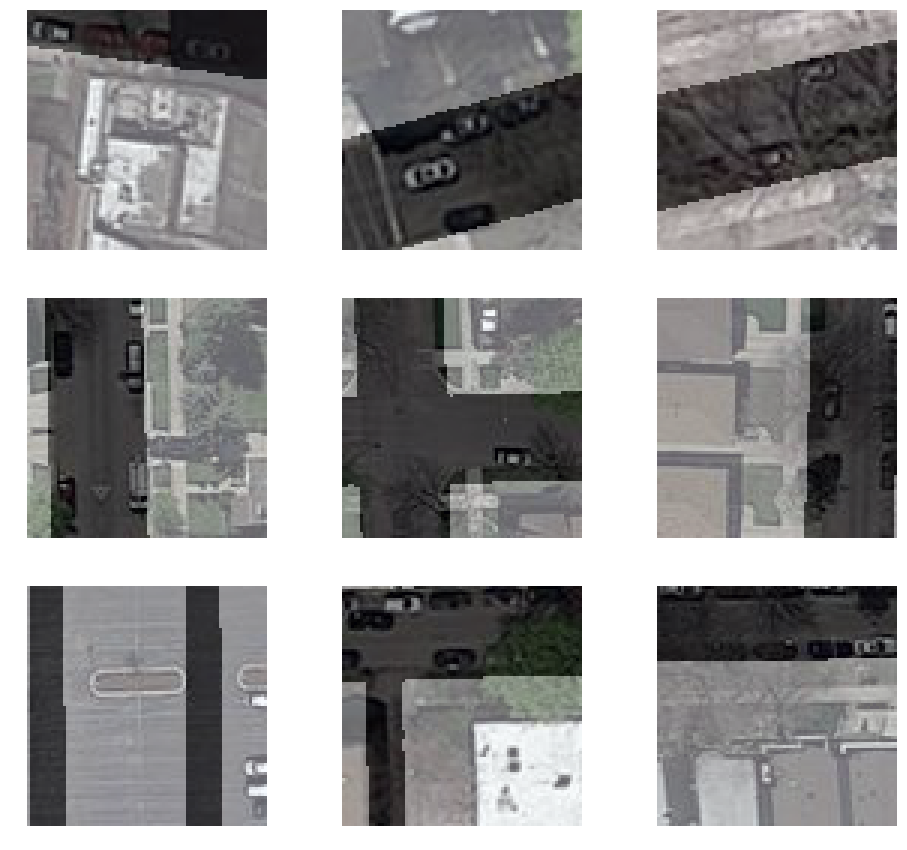

In [77]:
n_display = 9
id_display = np.random.permutation(len(useful_patches_tr))[:n_display]

plt.figure(figsize=(16, 5*(n_display//3)))
for i, id_ in enumerate(id_display):
    plt.subplot(n_display//3,3,i+1)
    # dont show the canny
    img = useful_patches_tr[id_,:,:,:3]
    plt.imshow( ( img - np.min(img) ) / np.max(img - np.min(img)) ); 
    plt.imshow(useful_lab_tr[id_], alpha=0.4); 
    plt.axis('off');
plt.show()

In [ ]:
import ml_utils.model as model

m = model.Model()
m.train_model(useful_patches_tr, useful_lab_tr, train_imgs_norm, train_gt, val_imgs_norm, val_gt, n_epoch=100)
name_model = m.save_path


conv1 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2 size (?, ?, ?, 128)
pool2 size (?, ?, ?, 128)
conv3 size (?, ?, ?, 256)
pool3 size (?, ?, ?, 256)
conv4 size (?, ?, ?, 256)
pool4 size (?, ?, ?, 256)
deconv1 size (?, ?, ?, 256)
deconv2 size (?, ?, ?, 256)
deconv3 size (?, ?, ?, 128)
deconv4 size (?, ?, ?, 64)
score size (?, ?, ?, 2)


In [8]:
#best results of 25 epochs with sigma =1.5 and canny : 0.896
#best results of 25 epochs with sigma =1.5 and canny with all augmented data: ???

AttributeError: module 'tensorflow' has no attribute '__version__'

# 3. Results vizualisation


In [ ]:
m = model.Model(display_log=False)
d = m.get_model_layers(train_imgs[2], 'model/2017_12_03_15h19_model.ckpt')
m.plot_layers(train_imgs_norm[2], d)

In [ ]:
y_pred_train = m.apply_model(train_imgs_norm, 'model/2017_12_03_15h19_model.ckpt')
print('F1-score train: {}'.format(m.predict_f1(train_gt, y_pred_train)))
y_pred_valid = m.apply_model(val_imgs_norm, 'model/2017_12_03_15h19_model.ckpt')
print('F1-score validation: {}'.format(m.predict_f1(val_gt, y_pred_valid)))

In [ ]:
rs.display_predictions(y_pred_train, train_imgs, train_gt)

In [ ]:
rs.display_predictions(y_pred_valid, val_imgs, val_gt)

# 3. Post Process

In [ ]:
test_img = rs.load_test_set(path_test)
test_img_norm, _, _ = rs.normalize_data(test_img, mode='all', mean_ref=mean_train, std_ref=std_train)

In [ ]:
m = model.Model(display_log=False)
y_pred_test = m.apply_model(test_img_norm, 'model/2017_12_03_15h19_model.ckpt')

In [ ]:
im_pred_test = np.reshape(y_pred_test, test_img.shape[:3]).astype(np.float32)
print(test_img.shape)
rs.display_predictions(y_pred_test, test_img)

In [ ]:
import skimage.measure
import skimage.draw
import skimage.morphology

def post_processing(imgs):
    imgs_post = np.zeros(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_post[i] = skimage.morphology.remove_small_objects(imgs[i].astype(bool), min_size = 200)    
    return imgs_post

im_pred_test_post = post_processing(im_pred_test)

rs.display_predictions(y_pred_test, test_img, im_pred_test_post)

# 4. Submission

In [ ]:
rs.create_submission(im_pred_test_post, 'test_25epoch_classexample_post.csv')